In [1]:
import numpy as np
from io import StringIO

In [2]:
import openai

with open("secret/secret_key_file.txt", 'r') as file:
    api_key = file.read().strip()

client = openai.OpenAI(api_key = api_key)

In [3]:
import pandas as pd
import re
from bs4 import BeautifulSoup

# Without error capture to ensure the output (whether success or failure) is reported back.
# Attempt to read tables from the HTML file using pandas
file_path = "data/Program - MSR 2022.html"

In [4]:
with open(file_path, 'r') as file:
    html_content = file.read()

In [5]:
soup = BeautifulSoup(html_content, 'lxml')

In [6]:
rows = soup.find_all('tr', class_='hidable')

In [7]:
# Regex to match date pattern (e.g., "Tue 16 May")
date_pattern = re.compile(r"\b(?:Mon|Tue|Wed|Thu|Fri|Sat|Sun)\s\d{1,2}\s(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)")

In [8]:
extracted_rows = []

# Loop through each row to extract required details
for row in rows:
    temp_row = []
    
    # Extract session details from parent div if not already extracted
    session_div = row.find_previous('div', class_='session-info-in-table')
    session = session_div.get_text(strip=True) if session_div else ''
    
    datetime_info = row.find('td', class_='text-right')
    talk_info = row.find_all('td')[-1]
    
    if datetime_info and talk_info:
        time = datetime_info.find('div', class_='start-time').get_text(strip=True) if datetime_info.find('div', class_='start-time') else ''
        duration = datetime_info.find('strong').get_text(strip=True) if datetime_info.find('strong') else ''
        
        # Calculate end time based on start time and duration if needed
        
        temp_row.append(time)
        # temp_row.append(end_time)  # Calculate and append end time if needed
        temp_row.append(duration)
        
        talk_title = talk_info.find('strong')
        if talk_title:
            temp_row.append(talk_title.get_text(strip=True))
            
            link = talk_title.find('a', href=True)
            temp_row.append(link['href'] if link else '')
        else:
            temp_row.extend(['', ''])
            
        # Extract authors
        authors_div = talk_info.find('div', class_='performers')
        authors = [author.get_text(strip=True) for author in authors_div.find_all('a')] if authors_div else []
        temp_row.append(authors)
        
        # Append session information
        temp_row.append(session)
        
        # Locate date information
        # Tip: You may need to adjust how you locate the 'date information' based on your HTML structure
        date_info = row.find_previous('div', class_='day-wrapper')
        if date_info:
            date_text = date_info.get_text(strip=True)
            matched_date = date_pattern.search(date_text)
            date = matched_date.group(0) if matched_date else "Date Not Found"
        else:
            date = None
        temp_row.append(date)
        
        extracted_rows.append(temp_row)

columns = ['Time', 'Duration', 'Talk Title', 'Link', 'Authors', 'Session', 'Date']
df = pd.DataFrame(extracted_rows, columns=columns)

df.head()

,Time,Duration,Talk Title,Link,Authors,Session,Date
0,22:00,4m,An Empirical Evaluation of GitHub Copilot’s Co...,#,"[Nhan Nguyen, Sarah Nadi]",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
1,22:04,4m,Comments on Comments: Where Code Review and Do...,#,"[Nikitha Rao, Jason Tsay, Martin Hirzel, Vince...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
2,22:08,7m,Does This Apply to Me? An Empirical Study of T...,#,"[Akalanka Galappaththi, Sarah Nadi, Christoph ...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
3,22:15,7m,Towards Reliable Agile Iterative Planning via ...,#,"[Jirat Pasuksmit, Patanamon Thongtanunam, Shan...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
4,22:22,7m,BotHunter: An Approach to Detect Software Bots...,#,"[Ahmad Abdellatif, Mairieli Wessel, Igor Stein...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May


In [9]:
# df = df.sample(n=50, random_state=101)

In [10]:
# Convert all column names to lowercase and replace spaces with hyphens
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Put date first
df = df[['date'] + [col for col in df.columns if col != 'date']]

# Convert Time to start_time as datetime and calculate end_time
df['start_time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%a %d %b %H:%M')
df['duration'] = df['duration'].str.extract('(\d+)').astype(int)  # Extract duration in minutes
df['end_time'] = df['start_time'] + pd.to_timedelta(df['duration'], unit='m')

# Delete the Link column
df = df.drop(['link', 'time'], axis=1)

# Move Authors column to the last position
df = df[[col for col in df.columns if col != 'authors'] + ['authors']]

df = df[['session', 'date', 'start_time', 'end_time', 'duration', 'talk_title','authors']]

# Display the final data frame
df.head()

,session,date,start_time,end_time,duration,talk_title,authors
0,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:00:00,1900-05-17 22:04:00,4,An Empirical Evaluation of GitHub Copilot’s Co...,"[Nhan Nguyen, Sarah Nadi]"
1,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:04:00,1900-05-17 22:08:00,4,Comments on Comments: Where Code Review and Do...,"[Nikitha Rao, Jason Tsay, Martin Hirzel, Vince..."
2,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:08:00,1900-05-17 22:15:00,7,Does This Apply to Me? An Empirical Study of T...,"[Akalanka Galappaththi, Sarah Nadi, Christoph ..."
3,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:15:00,1900-05-17 22:22:00,7,Towards Reliable Agile Iterative Planning via ...,"[Jirat Pasuksmit, Patanamon Thongtanunam, Shan..."
4,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:22:00,1900-05-17 22:29:00,7,BotHunter: An Approach to Detect Software Bots...,"[Ahmad Abdellatif, Mairieli Wessel, Igor Stein..."


In [11]:
df['start_time'] = pd.to_datetime(df['start_time']).astype(int) // 10**9 // 60
df['end_time'] = pd.to_datetime(df['end_time']).astype(int) // 10**9 // 60

df.head()

,session,date,start_time,end_time,duration,talk_title,authors
0,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619320,-36619316,4,An Empirical Evaluation of GitHub Copilot’s Co...,"[Nhan Nguyen, Sarah Nadi]"
1,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619316,-36619312,4,Comments on Comments: Where Code Review and Do...,"[Nikitha Rao, Jason Tsay, Martin Hirzel, Vince..."
2,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619312,-36619305,7,Does This Apply to Me? An Empirical Study of T...,"[Akalanka Galappaththi, Sarah Nadi, Christoph ..."
3,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619305,-36619298,7,Towards Reliable Agile Iterative Planning via ...,"[Jirat Pasuksmit, Patanamon Thongtanunam, Shan..."
4,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619298,-36619291,7,BotHunter: An Approach to Detect Software Bots...,"[Ahmad Abdellatif, Mairieli Wessel, Igor Stein..."


In [12]:
df = df[df["date"]=="Fri 20 May"]

In [13]:
df.dtypes

session       object
date          object
start_time     int64
end_time       int64
duration       int64
talk_title    object
authors       object
dtype: object

In [14]:
len(df)

33

In [15]:
df["session"].unique()[:3]

array(['Session 14: Software QualityTechnical Papers/Industry Track/Data and Tool Showcase TrackatMSR Main room - even hoursChair(s):Kla TantithamthavornMonash University,Simone ScalabrinoUniversity of Molise',
       'Session 15: Collaboration & Open SourceRegistered Reports/Data and Tool Showcase Track/Technical Papers/Industry TrackatMSR Main room - odd hoursChair(s):Massimiliano Di PentaUniversity of Sannio, Italy,Fiorella ZampettiUniversity of Sannio, Italy',
       'Tutorial: Using Datalore for Reproducible ResearchTutorialsatMSR Main room - odd hours'],
      dtype=object)

In [16]:
df[df["session"]=='Session 1Technical Papers/Registered ReportsatMSR Main room - even hoursChair(s):Hongyu ZhangUniversity of Newcastle,Masud RahmanDalhousie University']

,session,date,start_time,end_time,duration,talk_title,authors


In [17]:
def merge_intervals(intervals):
    if not intervals:
        return 0
    
    # Sort intervals by the start time
    intervals.sort(key=lambda x: x[0])
    
    merged = [intervals[0]]
    for current_start, current_end in intervals[1:]:
        last_end = merged[-1][1]
        
        if current_start <= last_end:
            # There's an overlap, extend the previous interval
            merged[-1] = (merged[-1][0], max(last_end, current_end))
        else:
            # No overlap, add this interval as is
            merged.append((current_start, current_end))
    
    # Compute total duration in minutes (or another unit as desired)
    total_duration_minutes = sum((end - start) for start, end in merged)   # convert seconds to minutes
    return total_duration_minutes

total_durations = []

for date, group in df.groupby('date'):
    intervals = list(zip(group['start_time'], group['end_time']))
    total_duration = merge_intervals(intervals)
    total_durations.append({'date': date, 'total_duration': total_duration})

# Converting the result into a DataFrame
total_duration_df = pd.DataFrame(total_durations)

total_duration_df

,date,total_duration
0,Fri 20 May,260


In [18]:
dates = df.groupby("date")["duration"].sum().reset_index()


dates

,date,duration
0,Fri 20 May,310


## Perform mathematical optimization using GPT

In [19]:
df_input = df[['talk_title', 'duration']].copy()

# Display the head of df_input to verify
df_input.head()

,talk_title,duration
116,Evaluating the effectiveness of local explanat...,4
117,Problems and Solutions in Applying Continuous ...,7
118,To Type or Not to Type? A Systematic Compariso...,7
119,Using Bandit Algorithms for Selecting Feature ...,7
120,Constructing Dataset of Functionally Equivalen...,4


In [20]:
sessions = df.groupby("session")["duration"].sum()

sessions.head()

session
HackathonHackathon/Technical PapersatMSR Main room - odd hoursChair(s):Gregorio RoblesUniversidad Rey Juan Carlos,Jesus M. Gonzalez-BarahonaUniversidad Rey Juan Carlos,Maëlick ClaesUniversity of Oulu                                                                                  50
Session 14: Software QualityTechnical Papers/Industry Track/Data and Tool Showcase TrackatMSR Main room - even hoursChair(s):Kla TantithamthavornMonash University,Simone ScalabrinoUniversity of Molise                                                                                 50
Session 15: Collaboration & Open SourceRegistered Reports/Data and Tool Showcase Track/Technical Papers/Industry TrackatMSR Main room - odd hoursChair(s):Massimiliano Di PentaUniversity of Sannio, Italy,Fiorella ZampettiUniversity of Sannio, Italy                                  50
Session 16: Non-functional Properties (Availability, Security, Legal Aspects)Industry Track/Technical Papers/Registered Reports/Data and Too

In [21]:
# Convert df_input to a string representation
df_input_str = df_input.sample(frac=1).to_string(index=False)

# Construct the start_prompt
start_prompt = f"""
Program creation is the process of taking all the accepted papers to a conference and allocating a presentation slot for each paper with parallel sessions. 
The PC chairs of a conference typically do this manually. 
Assign sessions to the following papers based on the following constraints:
1. The total length of all paper presentations within a session should be less than or equal to the length of the session they are in. 
2. No new sessions should be added. 
3. The "Discussions and Q&A" event should only be at the end of a session if present. 
4. All papers must be assigned to some session. 

The output should contain the schedule in the form of the csv representation of a data frame. This csv representation should be in three quotes (```) on both sides so that I can easily extract it from your result and make a data frame. 
Example output format(use as many rows as the actual number of papers):

```
session@talk_title@duration
231@An Empirical Study on Maintainable Method Size in Java@7
223@Improve Quality of Cloud Serverless Architectures through Software Repository Mining@7
15@Extracting corrective actions from code repositories@7
15@How to Improve Deep Learning for Software Analytics (a case study with code smell detection)@7
11@ReCover: a Curated Dataset for Regression Testing Research@4
```

The list of paper and session titles are below: 


Session Lengths:
{sessions.to_string(index=False)}

Paper durations:
{df_input_str}


Make sure all the papers are included in the schedule. 

"""

# Print the start_prompt to verify
print(start_prompt[:500])


Program creation is the process of taking all the accepted papers to a conference and allocating a presentation slot for each paper with parallel sessions. 
The PC chairs of a conference typically do this manually. 
Assign sessions to the following papers based on the following constraints:
1. The total length of all paper presentations within a session should be less than or equal to the length of the session they are in. 
2. No new sessions should be added. 
3. The "Discussions and Q&A" event


In [22]:
len(start_prompt)

6627

In [23]:
response = client.chat.completions.create(
    model= "gpt-4-0125-preview", #"gpt-3.5-turbo-0125",  # You can switch this to "gpt-4-turbo-preview", "gpt-3.5-turbo-0125"
    messages=[
        {
            "role": "user",
            "content": start_prompt
        },
    ],
    temperature=0.5,
    # max_tokens=256,
    top_p=0.5,
    frequency_penalty=0,
    presence_penalty=0
)
ans_string = response.choices[0].message.content

In [24]:
len(ans_string)

2433

In [25]:
print(ans_string)

```
session@talk_title@duration
1@Using Bandit Algorithms for Selecting Feature Reduction Techniques in Software Defect Prediction@7
1@Varangian: A Git Bot for Augmented Static Analysis@7
1@Bot Detection in GitHub Repositories@5
1@A Time Series-Based Dataset of Open-Source Software Evolution@4
1@Towards Understanding Barriers and Mitigation Strategies of Software Engineers with Non-traditional Educational and Occupational Backgrounds@4
1@Discussions and Q&A@20
2@Using Datalore for Reproducible Research@50
2@Discussions and Q&A@12
3@Extracting corrective actions from code repositories@7
3@GitRank: A Framework to Rank GitHub Repositories@5
3@Code Review Practices for Refactoring Changes: An Empirical Study on OpenStack@7
3@SECOM: Towards a convention for security commit messagesFOSS Impact Paper Award@7
3@Finding the Fun in Fundraising: Public Issues and Pull Requests in VC-backed Open-Core Companies@7
3@Discussions and Q&A@14
4@Evaluating the effectiveness of local explanation methods o

In [26]:
# Use regular expressions to find the CSV string
# The pattern looks for a string enclosed in triple quotes
match = re.search("```\n(.*?)\n```", ans_string, re.DOTALL)
if match:
    csv_string = match.group(1)  # Extract the actual CSV data
    # print("Extracted CSV:\n", csv_string)

    # Convert the CSV string to a DataFrame
    # StringIO is used to convert the string to a file-like object
    df_results = pd.read_csv(StringIO(csv_string), sep="@")

    # Display the DataFrame
    print("Got the df!")
else:
    print("No CSV data found in the string.")
    
df_results.head()

Got the df!


,session,talk_title,duration
0,1,Using Bandit Algorithms for Selecting Feature ...,7
1,1,Varangian: A Git Bot for Augmented Static Anal...,7
2,1,Bot Detection in GitHub Repositories,5
3,1,A Time Series-Based Dataset of Open-Source Sof...,4
4,1,Towards Understanding Barriers and Mitigation ...,4


In [27]:
df_results

,session,talk_title,duration
0,1,Using Bandit Algorithms for Selecting Feature ...,7
1,1,Varangian: A Git Bot for Augmented Static Anal...,7
2,1,Bot Detection in GitHub Repositories,5
3,1,A Time Series-Based Dataset of Open-Source Sof...,4
4,1,Towards Understanding Barriers and Mitigation ...,4
5,1,Discussions and Q&A,20
6,2,Using Datalore for Reproducible Research,50
7,2,Discussions and Q&A,12
8,3,Extracting corrective actions from code reposi...,7
9,3,GitRank: A Framework to Rank GitHub Repositories,5


In [28]:
df_results.shape

(35, 3)

## Check if the constraints are met

### Session Constraints

In [29]:
df_results.groupby("session")["duration"].sum().sort_values()

session
6    37
1    47
3    47
2    62
5    70
4    87
Name: duration, dtype: int64

In [30]:
np.array(sorted(sessions.values))

array([50, 50, 50, 50, 50, 60])

In [31]:
# Predictions, Trues. 
print("Checking the extent to which the constraints are met. If the numbers are different, then the ")
len(df_results.groupby("session")["duration"].sum().sort_values()), len(np.array(sorted(sessions.values)))

Checking the extent to which the constraints are met. If the numbers are different, then the 


(6, 6)

In [32]:
print("Checking the extent to which the constraints are met. Negative numbers are violations where the planned session is too long.")
session_count = 0
for truth, pred in zip(np.array(sorted(sessions.values))[::-1], df_results.groupby("session")["duration"].sum().sort_values().values[::-1]):
    session_count += 1
    print("Session ",session_count)
    if not truth:
        print(-pred)
    elif not pred:
        print(truth)
    else:
        print(truth-pred)

Checking the extent to which the constraints are met. Negative numbers are violations where the planned session is too long.
Session  1
-27
Session  2
-20
Session  3
-12
Session  4
3
Session  5
3
Session  6
13


### Paper constraints

In [33]:
df_results.shape, df.shape

((35, 3), (33, 7))

In [34]:
df.sort_values("talk_title")[["duration","talk_title"]]

,duration,talk_title
141,7,A Deep Study of the Effects and Fixes of Serve...
142,4,A Large-scale Dataset of (Open Source) License...
125,4,A Time Series-Based Dataset of Open-Source Sof...
127,4,A Versatile Dataset of Agile Open Source Softw...
128,7,Automatically Prioritizing and Assigning Tasks...
133,5,Bot Detection in GitHub Repositories
130,4,Can instability variations warn developers whe...
123,7,Code Review Practices for Refactoring Changes:...
120,4,Constructing Dataset of Functionally Equivalen...
145,7,Detecting Privacy-Sensitive Code Changes with ...


In [35]:
df_results.sort_values("talk_title")[["duration","talk_title"]]

,duration,talk_title
15,7,A Deep Study of the Effects and Fixes of Serve...
16,4,A Large-scale Dataset of (Open Source) License...
3,4,A Time Series-Based Dataset of Open-Source Sof...
17,4,A Versatile Dataset of Agile Open Source Softw...
18,7,Automatically Prioritizing and Assigning Tasks...
2,5,Bot Detection in GitHub Repositories
27,4,Can instability variations warn developers whe...
10,7,Code Review Practices for Refactoring Changes:...
19,4,Constructing Dataset of Functionally Equivalen...
22,7,Detecting Privacy-Sensitive Code Changes with ...


In [36]:
df_results[~df_results["talk_title"].isin(df["talk_title"])]

,session,talk_title,duration


In [37]:
df[~df["talk_title"].isin(df_results["talk_title"])]

,session,date,start_time,end_time,duration,talk_title,authors


## Improve iteratively


In [38]:
proposed_sessions = df_results.groupby("session")["duration"].sum()
proposed_sessions

session
1    47
2    62
3    47
4    87
5    70
6    37
Name: duration, dtype: int64

In [39]:
# Sorting the dataframes
sessions_sorted = sessions.sort_values(ascending=False)
proposed_sessions_sorted = proposed_sessions.sort_values(ascending=False)

# Initialize the output string
output_str = ""

# Iterate and compare values
for idx, val in proposed_sessions_sorted.items():
    if idx-1 < len(sessions_sorted):
        session_duration = sessions_sorted.iloc[idx-1]
        if val > session_duration:
            difference = val - session_duration
            output_str += f"The session number {idx} is larger by {difference} minutes. \n"
        else:
            difference = session_duration - val
            output_str += f"The session number {idx} is within limit by {difference} minutes and is therefore alright. \n"
    else:
        output_str += f"Session number {idx} is one too many. It should not exist. \n"

# Check if there are unused sessions in the original sessions dataframe
unused_sessions = len(sessions_sorted) - len(proposed_sessions_sorted)
if unused_sessions > 0:
    output_str += f"{unused_sessions} have not been used. \n"

if len(df) > len(df_results):
    output_str += f"""
    The proposed solution has only {len(df_results)} papers which is less than the target of {len(df)} by {len(df) - len(df_results)} papers.
    """
print(output_str)

The session number 4 is larger by 37 minutes. 
The session number 5 is larger by 20 minutes. 
The session number 2 is larger by 12 minutes. 
The session number 1 is within limit by 13 minutes and is therefore alright. 
The session number 3 is within limit by 3 minutes and is therefore alright. 
The session number 6 is within limit by 13 minutes and is therefore alright. 



In [40]:
N_ITERATIONS = 20

In [41]:
all_results = []

for i in range(N_ITERATIONS):
    print(f"Update {i}...")
    # Sorting the dataframes
    sessions_sorted = sessions.sort_values(ascending=False)
    proposed_sessions_sorted = proposed_sessions.sort_values(ascending=False)

    # Initialize the output string
    output_str = ""

    # Iterate and compare values
    for idx, val in proposed_sessions_sorted.items():
        if idx-1 < len(sessions_sorted):
            session_duration = sessions_sorted.iloc[idx-1]
            if val > session_duration:
                difference = val - session_duration
                output_str += f"The session number {idx} is larger by {difference} minutes. \n"
            else:
                difference = session_duration - val
                output_str += f"The session number {idx} is within limit by {difference} minutes and is therefore alright. \n"
        else:
            output_str += f"Session number {idx} is one too many. It should not exist. \n"

    # Check if there are unused sessions in the original sessions dataframe
    unused_sessions = len(sessions_sorted) - len(proposed_sessions_sorted)
    if unused_sessions > 0:
        output_str += f"{unused_sessions} have not been used. \n"

    if len(df) > len(df_results):
        output_str += f"""
        The proposed solution has only {len(df_results)} papers which is less than the target of {len(df)} by {len(df) - len(df_results)} papers.
        """
    
    print(output_str)
    
    new_prompt = start_prompt + f"""

    Current Solution:
    {df_results.to_string(index=False)}


    Feedback regarding the current solution: 

    """ + output_str + """
    Can you make a small modification to the current solution to address the above feedback? 
    I want the output in the same format as I mentioned above, so that I can extract the data frame. 
    """

    response = client.chat.completions.create(
    model= "gpt-4-0125-preview", #"gpt-3.5-turbo-0125",  # You can switch this to "gpt-4-turbo-preview", "gpt-3.5-turbo-0125"
        messages=[
            {
                "role": "user",
                "content": start_prompt
            },
        ],
        temperature=0.5,
        # max_tokens=256,
        top_p=0.5,
        frequency_penalty=0,
        presence_penalty=0
    )
    ans_string = response.choices[0].message.content
    
    match = re.search("```\n(.*?)\n```", ans_string, re.DOTALL)
    if match:
        csv_string = match.group(1)  # Extract the actual CSV data
        # print("Extracted CSV:\n", csv_string)

        # Convert the CSV string to a DataFrame
        # StringIO is used to convert the string to a file-like object
        df_results = pd.read_csv(StringIO(csv_string), sep="@")
        
        all_results.append(df_results)

        print("Got the df!")
    else:
        print("No CSV data found in the string. Abort!")
        break
        
    proposed_sessions = df_results.groupby("session")["duration"].sum()

    
            
            
            


Update 0...
The session number 4 is larger by 37 minutes. 
The session number 5 is larger by 20 minutes. 
The session number 2 is larger by 12 minutes. 
The session number 1 is within limit by 13 minutes and is therefore alright. 
The session number 3 is within limit by 3 minutes and is therefore alright. 
The session number 6 is within limit by 13 minutes and is therefore alright. 

Got the df!
Update 1...
The session number 4 is larger by 34 minutes. 
The session number 2 is larger by 12 minutes. 
The session number 5 is larger by 12 minutes. 
The session number 3 is within limit by 0 minutes and is therefore alright. 
The session number 1 is within limit by 13 minutes and is therefore alright. 
The session number 6 is within limit by 13 minutes and is therefore alright. 

Got the df!
Update 2...
The session number 4 is larger by 34 minutes. 
The session number 2 is larger by 12 minutes. 
The session number 5 is larger by 12 minutes. 
The session number 3 is within limit by 0 minutes

KeyError: 'session'

In [42]:
df_results.head()

,1,Using Datalore for Reproducible Research,50
0,1,Discussions and Q&A,20
1,2,Software Bots in Software Engineering: Benefit...,50
2,2,Discussions and Q&A,17
3,3,Using Bandit Algorithms for Selecting Feature ...,7
4,3,Varangian: A Git Bot for Augmented Static Anal...,7


### Analyze the progress

In [43]:
data = {
    'Session': ['1', '2', '3', '4', '5', '6'],
    'Update 0': [0, 12, 0, 37, 20, 0],
    'Update 1': [0, 12, 0, 34, 12, 0],
    'Update 2': [0, 12, 0, 34, 12, 0],
    'Update 3': [0, 12, 0, 33, 20, 0],
    'Update 4': [0, 0, 0, 1, 0, 24],
    'Update 5': [0, 17, 0, 36, 17, 0],
    'Update 6': [0, 12, 0, 34, 20, 0],
    'Update 7': [0, 0, 0, 16, 0, 0],
    'Update 8': [0, 12, 0, 33, 20, 0],
    'Update 9': [0, 12, 0, 16, 14, 0],
    'Update 10': [0, 12, 0, 37, 14, 0],
    'Update 11': [0, 12, 0, 33, 20, 0],
    'Update 12': [0, 12, 0, 9, 21, 0]
}

# Convert the data into a DataFrame
df_overshoots = pd.DataFrame(data)
df_overshoots.set_index('Session', inplace=True)

df_overshoots

,Update 0,Update 1,Update 2,Update 3,Update 4,Update 5,Update 6,Update 7,Update 8,Update 9,Update 10,Update 11,Update 12
Session,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12,12,12,12,0,17,12,0,12,12,12,12,12
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37,34,34,33,1,36,34,16,33,16,37,33,9
5,20,12,12,20,0,17,20,0,20,14,14,20,21
6,0,0,0,0,24,0,0,0,0,0,0,0,0


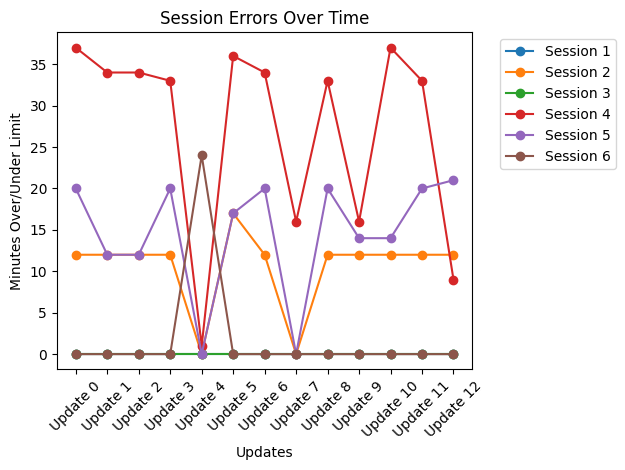

In [45]:
import matplotlib.pyplot as plt

# Plotting each session's errors over the updates.
for session in df_overshoots.index:
    plt.plot(df_overshoots.columns, df_overshoots.loc[session], marker='o', linestyle='-', label=f'Session {session}')

plt.xlabel('Updates')
plt.ylabel('Minutes Over/Under Limit')
plt.title('Session Errors Over Time')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [47]:
df_overshoots.sum(0)

Update 0     69
Update 1     58
Update 2     58
Update 3     65
Update 4     25
Update 5     70
Update 6     66
Update 7     16
Update 8     65
Update 9     42
Update 10    63
Update 11    65
Update 12    42
dtype: int64

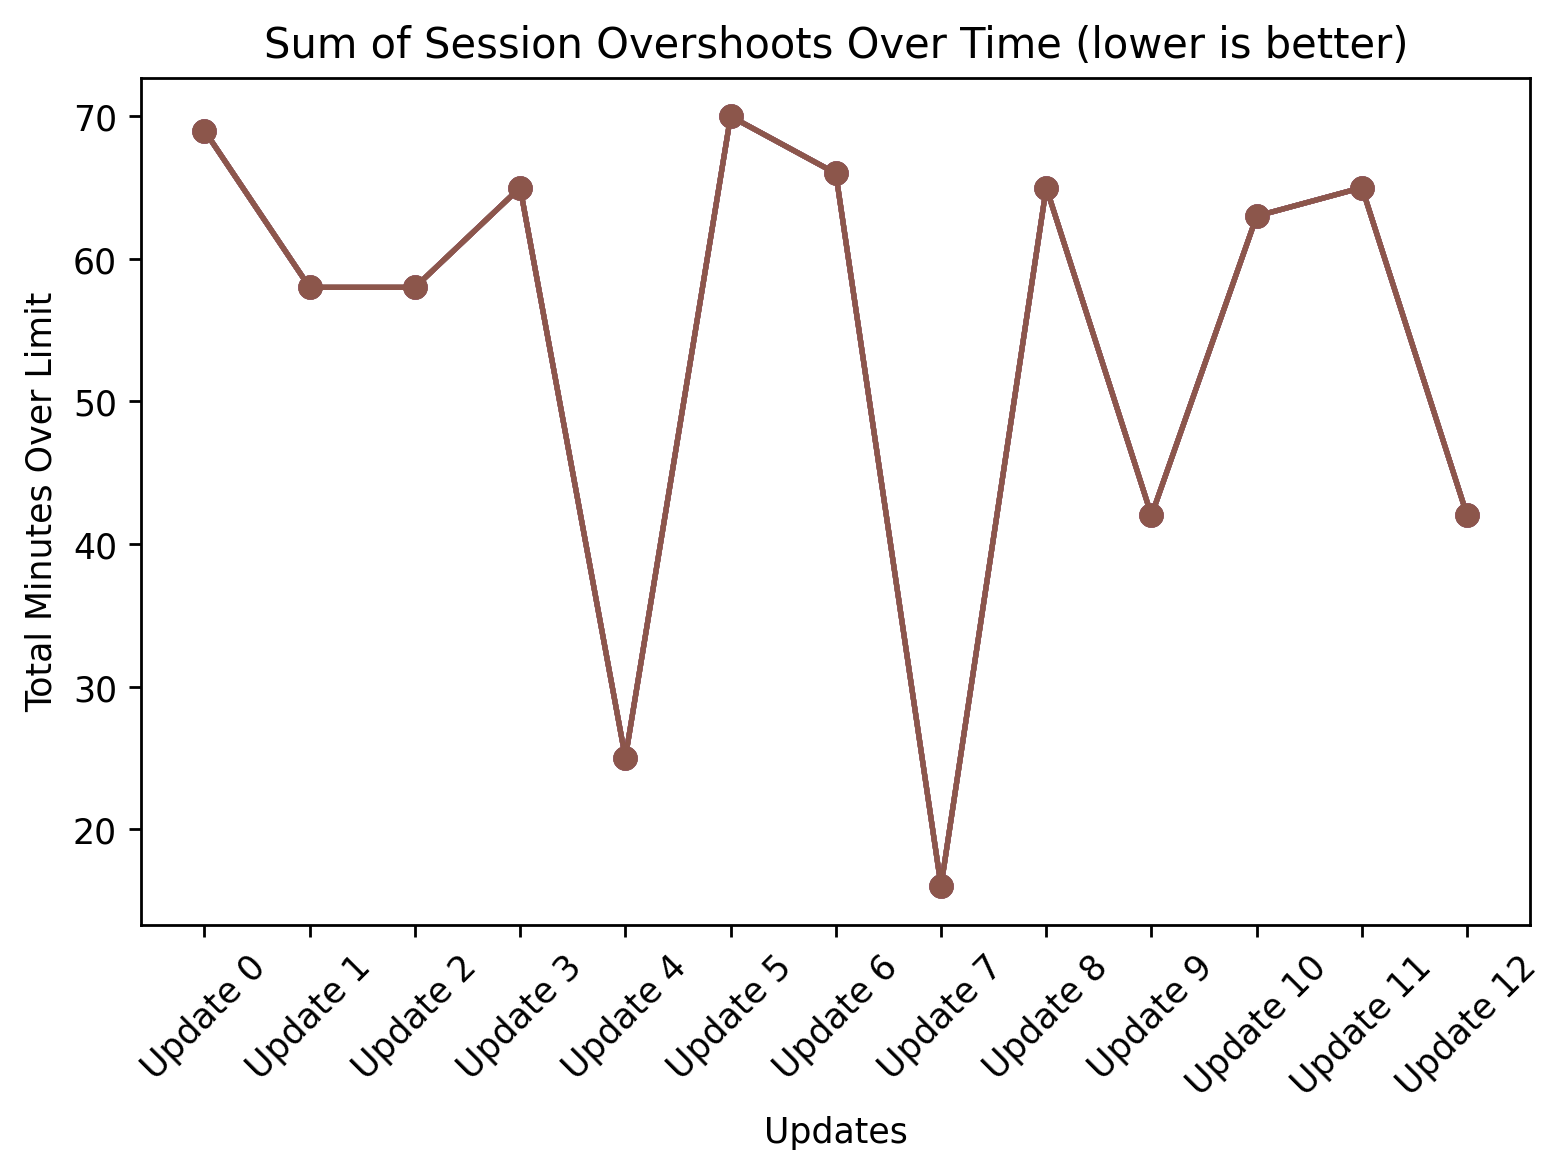

In [51]:
import matplotlib.pyplot as plt

# Plotting each session's errors over the updates.
plt.figure(dpi=250)
for session in df_overshoots.index:
    plt.plot(df_overshoots.sum(0), marker='o', linestyle='-')

plt.xlabel('Updates')
plt.ylabel('Total Minutes Over Limit')
plt.title('Sum of Session Overshoots Over Time (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()